In [1]:
import jax.numpy as jnp
# import netket_pro as nkp
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
# from grad_sample.utils.plotting_setup import *
import json
from matplotlib.cm import viridis, seismic, coolwarm, Spectral


In [2]:

out_dict = {}
# Define the main folder
main_folder = "/home/amisery/scratch_link/qchem_test/947_0/L20/NNBF/16"
# Iterate through subfolders
rel_err = []
max_snr = []
snr_psisq = []
snr_alpha = []
alpha_opt = []
for subfolder in os.listdir(main_folder):
    subfolder_path = os.path.join(main_folder, subfolder)
    # Check if the subfolder name is in the form a_b
    # Process run log files in the subfolder
    if os.path.isdir(subfolder_path):
        for file in os.listdir(subfolder_path):
            if file.startswith("run_") and file.endswith(".log"):
                file_path = os.path.join(subfolder_path, file)
                try:
                    with open(file_path, 'r') as f:
                        log_data = json.load(f)
                        rel_err_vals = log_data["rel_err"]["value"]
                        rel_err_it = log_data['rel_err']['iters']
                        idx_sort = jnp.flip(jnp.argsort(jnp.array(rel_err_vals)))

                        max_snr = jnp.array(log_data['max_snr_a']['value'])[idx_sort]
                        snr_psisq = jnp.array(log_data['snr_psi_sq']['value'])[idx_sort]
                        snr_alpha = jnp.array(log_data['snr_psi_sq']['value'])[idx_sort,:]
                        rel_err_vals_s = jnp.array(rel_err_vals)[idx_sort]
                        alpha_opt = jnp.array(log_data['argmax_snr_a']['value'])[idx_sort]
                        
                except (json.JSONDecodeError, KeyError):
                    print(f"Warning: Could not parse file {file_path}")

    # Prepare data for the heatmap
    rel_err_val_l = jnp.stack(rel_err_val_l)
    mean_rel = jnp.mean(rel_err_val_l,axis=0)
    std_rel = jnp.std(rel_err_val_l,axis=0)
    ymax = mean_rel + std_rel/(2*jnp.sqrt(2))
    ymin = mean_rel - std_rel/(2*jnp.sqrt(2))
    # plt.plot(rel_err_it, mean_rel, color = colors[idx], label=r'$\alpha = %s$'%key + ' , failure ratio %.2f'%(1 - num_cv/num_runs))


# plt.fill_between(rel_err_it, ymax, ymin, color = 'black', alpha=0.3)

NameError: name 'rel_err_val_l' is not defined

In [13]:
def get_main_folder_from_key(model):
    if model == 'j1j120.5':
        return '/home/amisery/scratch_link/j1j12_fs/J1J21d_0.5/L16/RBM/3/0.015_1e-06', 750, 'j1j1205_16sites'
    elif model == 'n2':
        return "/home/amisery/scratch_link/qchem_fs/947_0/L20/NNBF/16/schedule_0.0002", 250, 'N2_nnbf'
    elif model == 'heisenberg':
        return '/home/amisery/scratch_link/j1j12_fs/heisenberg1d_1.0/L16/RBM/3/0.015_1e-06', 750, 'heisenberg_16sites'

In [24]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store data from all runs
rel_err_all = []
max_snr_all = []
snr_psisq_all = []
snr_alpha_all = []
alpha_opt_all = []
snr_a_all = []
snr_grad_all = []

# model = 'j1j120.5'
model = 'heisenberg'
# model= 'n2'
main_folder, length, title = get_main_folder_from_key(model)

# Loop through subfolders
# for subfolder in os.listdir(main_folder):
#     subfolder_path = os.path.join(main_folder, subfolder)

#     if os.path.isdir(subfolder_path):
for file in os.listdir(main_folder):
    if file.startswith("run_") and file.endswith(".log"):
        file_path = os.path.join(main_folder, file)
        try:
            with open(file_path, 'r') as f:
                log_data = json.load(f)

            # Extract data
            rel_err_vals = np.array(log_data["rel_err"]["value"])

            # FILTER: Ignore files where rel_err_vals is not length 250
            if len(rel_err_vals) != length:
                print(f"Skipping {file_path}: rel_err_vals length {len(rel_err_vals)} != {length}")
                continue
            # Sort by rel_err_vals in descending order
            idx_sort = np.flip(np.argsort(rel_err_vals))

            # Append sorted data
            rel_err_all.append(rel_err_vals[idx_sort])
            max_snr_all.append(np.array(log_data['max_snr_a']['value'])[idx_sort])
            snr_psisq_all.append(np.array(log_data['snr_psi_sq']['value'])[idx_sort])
            snr_alpha_all.append(np.array(log_data['snr_psi_sq']['value'])[idx_sort])  # Fix potential slicing issue
            alpha_opt_all.append(np.array(log_data['argmax_snr_a']['value'])[idx_sort])
            snr_a_all.append(log_data["snr_a"]["value"])
            snr_grad_all.append(log_data['snr_grad']['value'])
        except (json.JSONDecodeError, KeyError, IndexError) as e:
            print(f"Warning: Could not parse file {file_path}. Error: {e}")

# Convert to numpy arrays
rel_err_all = np.array(rel_err_all)
max_snr_all = np.array(max_snr_all)
snr_psisq_all = np.array(snr_psisq_all)
alpha_opt_all = np.array(alpha_opt_all)
snr_a_all = np.array(snr_a_all)  # Shape (num_runs, 250, 20)
snr_grad_all = np.array(snr_grad_all)

# Create a dictionary with keys removing '_all'
data_dict = {
    "rel_err": rel_err_all,
    "max_snr": max_snr_all,
    "snr_psisq": snr_psisq_all,
    "alpha_opt": alpha_opt_all,
    "snr_a": snr_a_all,
    "snr_grad": snr_grad_all,
}

# Save to a compressed npz file
np.savez_compressed(f"data_snr_{model}.npz", **data_dict)

Data loaded


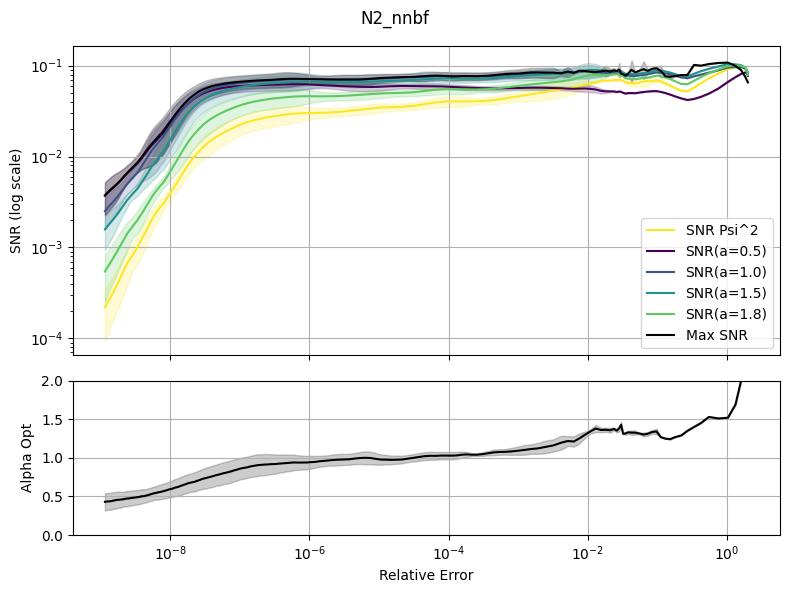

In [ ]:
# Load the .npz file
loaded_data = np.load("data_snr_j1j120.5.npz")

# Restore variables with '_all' suffix to match original names
rel_err_all = loaded_data["rel_err"]
max_snr_all = loaded_data["max_snr"]
snr_psisq_all = loaded_data["snr_psisq"]
alpha_opt_all = loaded_data["alpha_opt"]
snr_a_all = loaded_data["snr_a"]
snr_grad_all = loaded_data["snr_grad"]

print("Data loaded")

def moving_average(data, window_size=5):
    """Applies a simple moving average with the given window size."""
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Find indices for a = 0.5, 1.0, 1.5
a_values = np.linspace(0.1, 2, 200)[::20]  # Shape (20,
target_a = [0.5, 1.0, 1.5, 1.8]
cmap_a = viridis(jnp.linspace(0, 1,1+len(target_a)))

a_indices = [np.argmin(np.abs(a_values - ta)) for ta in target_a]

# Extract SNR(a) at these indices
snr_a_selected = snr_a_all[:, :, a_indices]  # Shape (num_runs, 250, 3)
smoothed_snr_a_selected = np.array([[moving_average(run[:, i], window_size=5) for i in range(snr_a_selected.shape[2])] for run in snr_a_selected])
smoothed_snr_a_selected = np.transpose(smoothed_snr_a_selected, (0, 2, 1))  # Shape (num_runs, new_length, 3)
# Compute mean & std for snr_a at selected indices
mean_snr_a = np.mean(smoothed_snr_a_selected, axis=0)  # Shape (250, 3)
std_snr_a = np.std(smoothed_snr_a_selected, axis=0)

# Apply moving average BEFORE averaging across runs
smoothed_rel_err_all = np.array([moving_average(run, window_size=5) for run in rel_err_all])
smoothed_snr_psisq_all = np.array([moving_average(run, window_size=5) for run in snr_psisq_all])
# Compute mean & std after smoothing
mean_rel_err = np.mean(smoothed_rel_err_all, axis=0)
mean_max_snr = np.mean(max_snr_all[:, :len(mean_rel_err)], axis=0)  # Trim to match new length
std_max_snr = np.std(max_snr_all[:, :len(mean_rel_err)], axis=0)
mean_snr_psisq = np.mean(smoothed_snr_psisq_all, axis=0)
std_snr_psisq = np.std(smoothed_snr_psisq_all, axis=0)
mean_alpha_opt = np.mean(alpha_opt_all[:, :len(mean_rel_err)], axis=0)
std_alpha_opt = np.std(alpha_opt_all[:, :len(mean_rel_err)], axis=0)


# -----------------------------
# PLOTTING (Using fill_between for Std Dev)
# -----------------------------
import matplotlib.pyplot as plt

# Create figure and subplots
fig, axes = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2, 1]}, figsize=(8, 6))

# -----------------------------
# Top Plot: SNRs (Log Scale)
# -----------------------------

axes[0].plot(mean_rel_err, mean_snr_psisq, label="SNR Psi^2", color=cmap_a[-1])
axes[0].fill_between(mean_rel_err, mean_snr_psisq - std_snr_psisq, mean_snr_psisq + std_snr_psisq, color=cmap_a[-1], alpha=0.2)
# Plot SNR(a) for a = 0.5, 1.0, 1.5
colors = ["purple", "orange", "cyan"]
for i, a_val in enumerate(target_a):
    axes[0].plot(mean_rel_err, mean_snr_a[:, i], label=f"SNR(a={a_val})", color=cmap_a[i])
    axes[0].fill_between(mean_rel_err, mean_snr_a[:, i] - std_snr_a[:, i], mean_snr_a[:, i] + std_snr_a[:, i], color=cmap_a[i], alpha=0.2)
axes[0].plot(mean_rel_err, mean_max_snr, label="Max SNR", color="black")
axes[0].fill_between(mean_rel_err, mean_max_snr - std_max_snr, mean_max_snr + std_max_snr, color="black", alpha=0.2)

axes[0].set_yscale("log")  # Log scale for SNR
axes[0].set_xscale("log") 
axes[0].set_ylabel("SNR (log scale)")
axes[0].legend()
axes[0].grid()

# -----------------------------
# Bottom Plot: Alpha Opt
# -----------------------------
axes[1].plot(mean_rel_err, mean_alpha_opt, label="Alpha Opt", color="black")
axes[1].fill_between(mean_rel_err, mean_alpha_opt - std_alpha_opt, mean_alpha_opt + std_alpha_opt, color="black", alpha=0.2)

axes[1].set_ylim(0, 2)  # Y-ticks between 0 and 2
axes[1].set_ylabel("Alpha Opt")
axes[1].set_xlabel("Relative Error")
axes[1].grid()
# fig.suptitle('J1J2 chain, 16sites, J2=0.5')
fig.suptitle(title)
# axes[0].set_ylim(bottom = 1e-4)
# fig.suptitle('N2 molecule')
# Show plot
plt.tight_layout()
plt.show()